In [1]:
# Parkinsonics Other Measures Data Analysis - GDS15
# Kevin Li
# 05.18.2020

import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.stats.multitest as smt
import statsmodels.api as sm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import os
import missingno as msno

## Exploratory Data Analysis of GDS Data

In [2]:
# Load GDS scores
gdsdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures\GDS_all_visits_08252016.xlsx')

# Clean up column names: remove "gds15_" from beginning
newcols=['ID']
for i in gdsdf.columns[1:]:
    newcols.append(i[6:])
gdsdf.columns=newcols
    
# Load randomization patient ID list
IDdf=pd.read_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Parkinsonics_RandID_ List_DID.xlsx')
IDdf=IDdf[:-5]
S_group=IDdf.loc[IDdf['First Intervention']=='S']
D_group=IDdf.loc[IDdf['First Intervention']=='D']
M_gen=IDdf.loc[IDdf['Gender']=='M']
F_gen=IDdf.loc[IDdf['Gender']=='F']

# Clean datatypes
IDdf['ID']=IDdf['ID'].astype(float)
IDsort=IDdf['ID'].sort_values().reset_index()['ID']

# Concat ID data to the main dataframe
gdsdf=pd.merge(gdsdf, IDdf, on='ID')

Find percentage of missing data

In [12]:
miss_count=0
tot_count=0
for col in range(len(gdsdf.columns)-4):
    for row in range(26):
        tot_count+=1
        if np.isnan(gdsdf.iloc[row, col]):
            miss_count+=1
                
miss_ratio=miss_count/tot_count
miss_ratio

0.011498810467882634

Separate items of GDS15 data, all timepoints in one df

In [4]:
i1=['ID', 'item1_BL', 'item1_V01', 'item1_V02', 'item1_V03', 'item1_V04', 'item1_V05']
i2=['ID', 'item2_BL', 'item2_V01', 'item2_V02', 'item2_V03', 'item2_V04', 'item2_V05']
i3=['ID', 'item3_BL', 'item3_V01', 'item3_V02', 'item3_V03', 'item3_V04', 'item3_V05']
i4=['ID', 'item4_BL', 'item4_V01', 'item4_V02', 'item4_V03', 'item4_V04', 'item4_V05']
i5=['ID', 'item5_BL', 'item5_V01', 'item5_V02', 'item5_V03', 'item5_V04', 'item5_V05']
i6=['ID', 'item6_BL', 'item6_V01', 'item6_V02', 'item6_V03', 'item6_V04', 'item6_V05']
i7=['ID', 'item7_BL', 'item7_V01', 'item7_V02', 'item7_V03', 'item7_V04', 'item7_V05']
i8=['ID', 'item8_BL', 'item8_V01', 'item8_V02', 'item8_V03', 'item8_V04', 'item8_V05']
i9=['ID', 'item9_BL', 'item9_V01', 'item9_V02', 'item9_V03', 'item9_V04', 'item9_V05']
i10=['ID', 'item10_BL', 'item10_V01', 'item10_V02', 'item10_V03', 'item10_V04', 'item10_V05']
i11=['ID', 'item11_BL', 'item11_V01', 'item11_V02', 'item11_V03', 'item11_V04', 'item11_V05']
i12=['ID', 'item12_BL', 'item12_V01', 'item12_V02', 'item12_V03', 'item12_V04', 'item12_V05']
i13=['ID', 'item13_BL', 'item13_V01', 'item13_V02', 'item13_V03', 'item13_V04', 'item13_V05']
i14=['ID', 'item14_BL', 'item14_V01', 'item14_V02', 'item14_V03', 'item14_V04', 'item14_V05']
i15=['ID', 'item15_BL', 'item15_V01', 'item15_V02', 'item15_V03', 'item15_V04', 'item15_V05']
tot=['ID', 'BL', 'V01', 'V02', 'V03', 'V04', 'V05']

items=[i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12, i13, i14, i15, tot]

Implement LOCF for missing data points + Catch missing data in lists

In [5]:
# Step 1: Check BL for each subscore, drop patients with nan values for that subscore & Total
# This loop is clean; all values present at baseline
# Add the missing IDs to a list for comparison in later steps
miss_ID=[0]
miss_item=['blank']
miss_group=[0]
copydf=gdsdf.copy()
for i in range(16):
    itemtps=items[i]
    for ID in range(26):
        if np.isnan(copydf.iloc[ID, i+1]):
            if miss_item[0]=='blank':
            # If the missing items list is unpopulated
                miss_item[0]=i
                miss_ID[0]=[gdsdf['ID'][ID]]
                miss_group[0]=[gdsdf['First Intervention'][ID]]
            else:
            # The missing items list has elements
                count1=0
                for m_items in miss_item:
                    if m_items==i:
                        count2=0
                        for m_ID in miss_ID[-1]:
                            if m_ID==gdsdf['ID'][ID]:
                                count2+=1
                        if count2==0:
                            miss_ID[-1].append(gdsdf['ID'][ID])
                            miss_group[-1].append(gdsdf['First Intervention'][ID])
                        count1+=1
                if count1==0:
                    miss_item.append(i)
                    miss_ID.append([gdsdf['ID'][ID]])
                    miss_group.append([gdsdf['First Intervention'][ID]])
            for tp in range(1,7):
                copydf.loc[ID, itemtps[tp]]=float('nan')
                copydf.loc[ID, tot[tp]]=float('nan')
                
            
# Step 2: Check V1-V5 for each subscore, carry forward last observation in place of missing data
for i in range(16):
    itemtps=items[i]
    itemdf=copydf[itemtps]
    for ID in range(26):
        for tp in range(2,7):
            if np.isnan(itemdf.iloc[ID, tp]):
                if miss_item[0]=='blank':
                # If the missing items list is unpopulated
                    miss_item[0]=i
                    miss_ID[0]=[gdsdf['ID'][ID]]
                    miss_group[0]=[gdsdf['First Intervention'][ID]]
                else:
                # The missing items list has elements
                    count1=0
                    for j in range(len(miss_item)):
                        if miss_item[j]==i:
                            count2=0
                            for m_ID in miss_ID[j]:
                                if m_ID==gdsdf['ID'][ID]:
                                    count2+=1
                            if count2==0:
                                miss_ID[j].append(gdsdf['ID'][ID])
                                miss_group[j].append(gdsdf['First Intervention'][ID])
                            count1+=1
                    if count1==0:
                        miss_item.append(i)
                        miss_ID.append([gdsdf['ID'][ID]])
                        miss_group.append([gdsdf['First Intervention'][ID]])
                itemdf.iloc[ID, tp]=itemdf.iloc[ID, tp-1]
    if i==0:
        locfdf=itemdf
    else:
        locfdf=pd.concat([locfdf, itemdf.iloc[:, 1:]], axis=1, sort=False)
        
locfdf=pd.merge(locfdf, IDdf, on='ID')

C:\Users\kevin\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Modify non-LOCF data to match format of LOCF dataframe

In [6]:
for i in range(16):
    if i==0:
        origdf=gdsdf[items[i]]
    else:
        origdf=pd.merge(origdf, gdsdf[items[i]], on='ID')
origdf=pd.concat([origdf, gdsdf[['Age', 'Gender', 'Hoehn & Yahr', 'First Intervention']]], axis=1)

Stratify VRQOL by group

In [7]:
# LOCF data:
S_gds_locf=locfdf.loc[locfdf['First Intervention']=='S']
D_gds_locf=locfdf.loc[locfdf['First Intervention']=='D']

# Original data:
S_gds_orig=origdf.loc[gdsdf['First Intervention']=='S']
D_gds_orig=origdf.loc[gdsdf['First Intervention']=='D']

# Missing data visualisation

Utilize missingno to create nullity matrix and nullity correlation heatmap between all vars

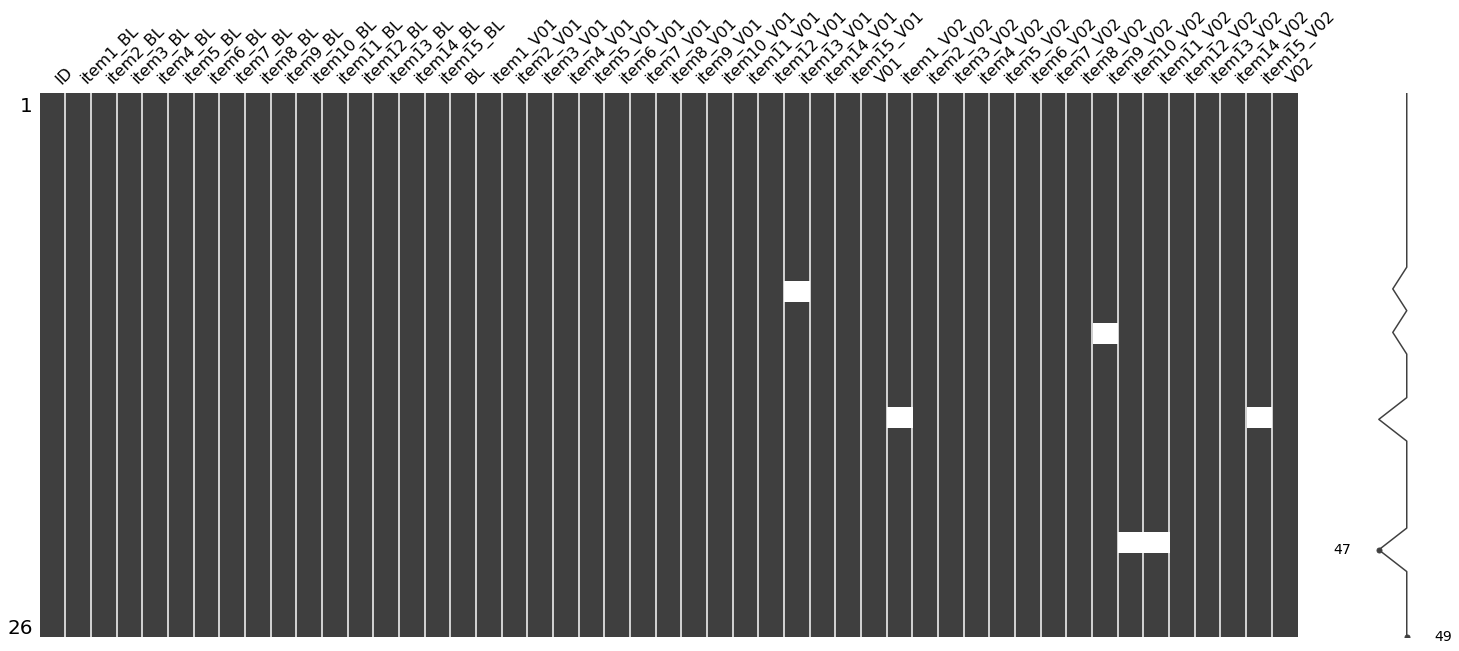

In [15]:
msno.matrix(gdsdf.loc[:, :'V02'])

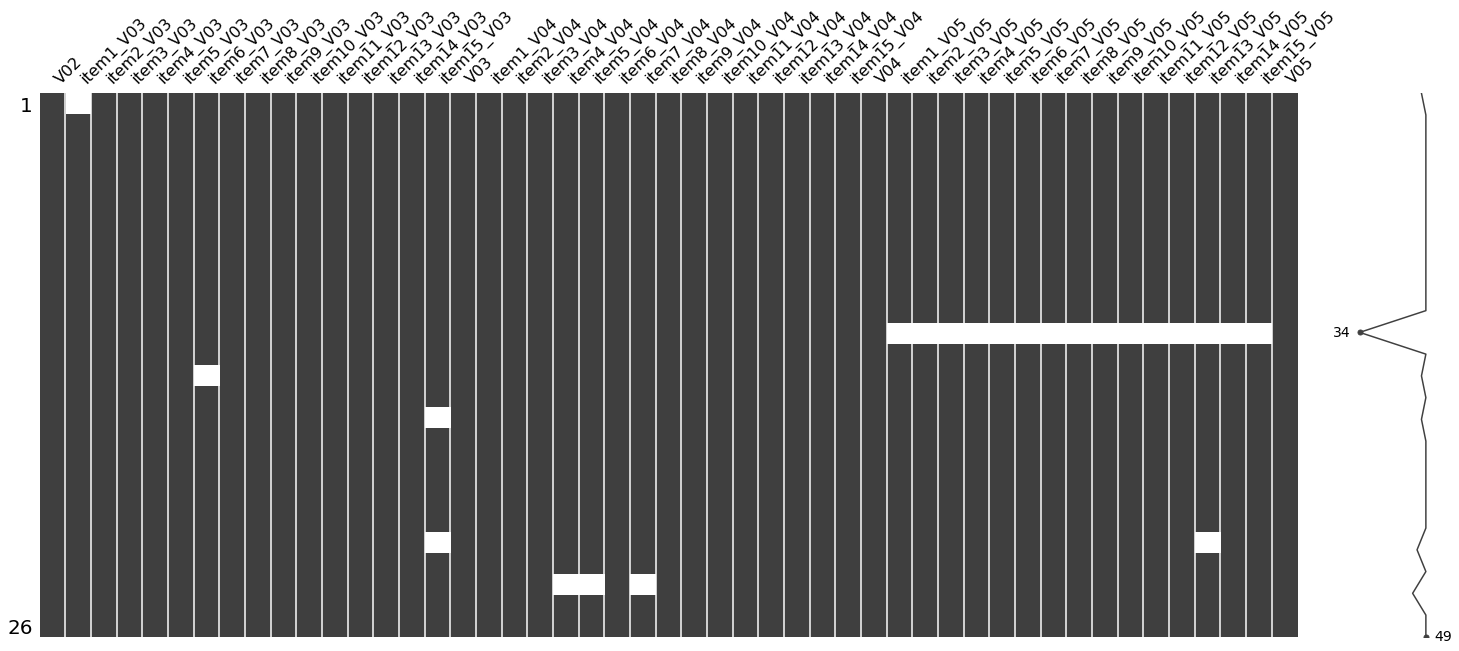

In [17]:
msno.matrix(gdsdf.loc[:, 'V02':'V05'])

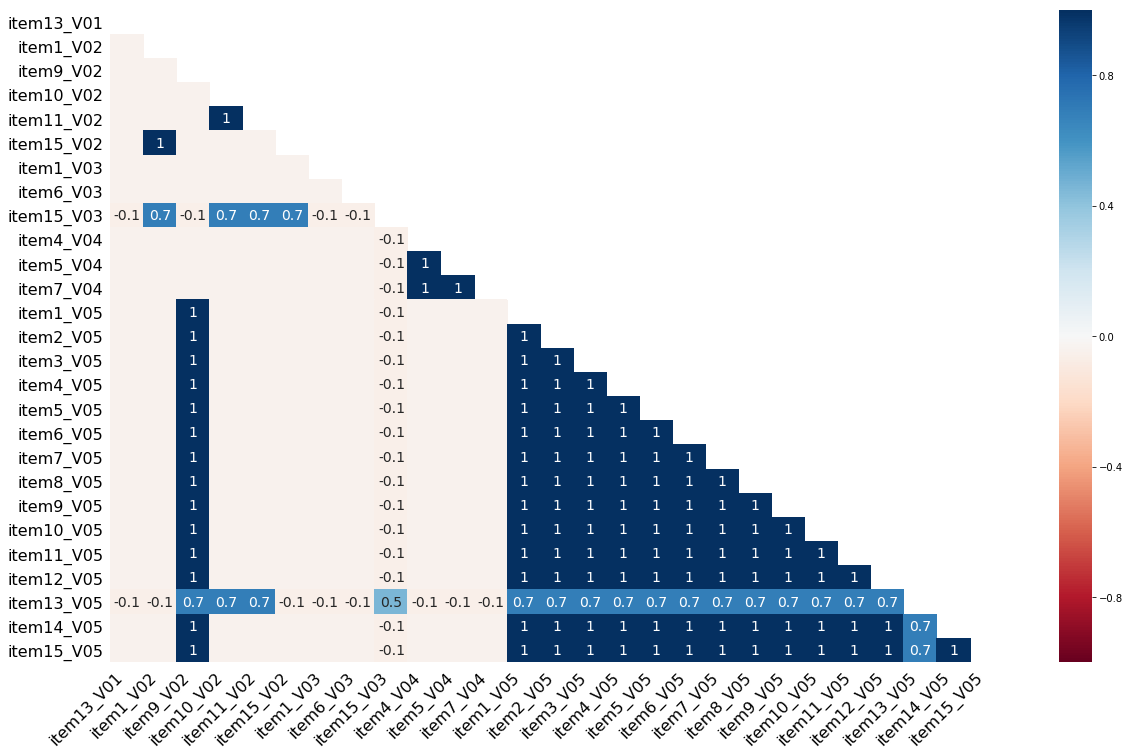

In [11]:
msno.heatmap(gdsdf)

# All Participants/Groupwise Plots - Spaghetti

Start-end paired T-tests

In [133]:
# One p value for each item
# Create 2 initial dfs to append to within each loop

# LOCF data:
S_se_locf=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'])
D_se_locf=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'])

count=1
for i in range(16):
    if i!=15:
        itemnum=str(count)
    elif i==15:
        itemnum='Tot'
    # Make a list of temp dataframes to iterate thru
    S_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    D_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    tempdflist=[S_temp, D_temp]
    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    S_se=S_gds_locf[items[i]].iloc[:, np.r_[1,6]]
    D_se=D_gds_locf[items[i]].iloc[:, np.r_[1,6]]
    sedflist=[S_se, D_se]

    for j in range(2):
        tempdf=tempdflist[j]
        tempgds=sedflist[j]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(tempgds.iloc[:, 0].astype(np.float64), tempgds.iloc[:, 1].astype(np.float64), nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempgds.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempgds.iloc[:, 1])

        if j==0:            
            S_se_locf=pd.concat([S_se_locf, tempdf], sort=False)
        elif j==1:
            D_se_locf=pd.concat([D_se_locf, tempdf], sort=False)
    count+=1
    
    
# Original data:
S_se_orig=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'])
D_se_orig=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'])

count=1
for i in range(16):
    if i!=15:
        itemnum=str(count)
    elif i==15:
        itemnum='Tot'
    # Make a list of temp dataframes to iterate thru
    S_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    D_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V5 Mean'], index=[str(count)])
    tempdflist=[S_temp, D_temp]
    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    S_se=S_gds_orig[items[i]].iloc[:, np.r_[1,6]]
    D_se=D_gds_orig[items[i]].iloc[:, np.r_[1,6]]
    sedflist=[S_se, D_se]

    for j in range(2):
        tempdf=tempdflist[j]
        tempgds=sedflist[j]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(tempgds.iloc[:, 0].astype(np.float64), tempgds.iloc[:, 1].astype(np.float64), nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempgds.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempgds.iloc[:, 1])

        if j==0:            
            S_se_orig=pd.concat([S_se_orig, tempdf], sort=False)
        elif j==1:
            D_se_orig=pd.concat([D_se_orig, tempdf], sort=False)
    count+=1


C:\Users\kevin\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\kevin\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\kevin\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [202]:
S_se_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\LOCF\GDS15_TTest_StartEnd_S_LOCF.xlsx')
D_se_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\LOCF\GDS15_TTest_StartEnd_D_LOCF.xlsx')

S_se_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\Original\GDS15_TTest_StartEnd_S_Orig.xlsx')
D_se_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\Original\GDS15_TTest_StartEnd_D_Orig.xlsx')

Plots: S Group - Singing First

LOCF Data Plots


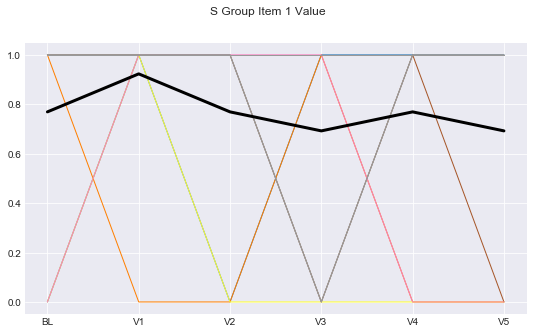

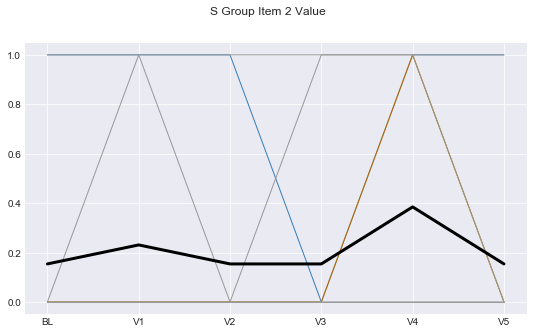

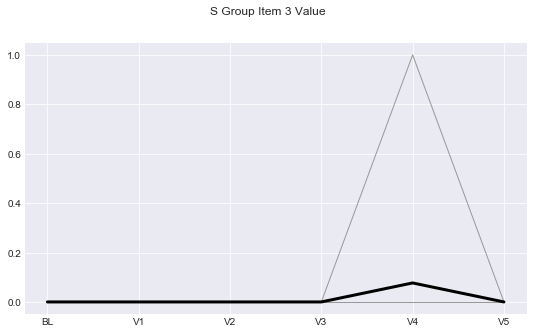

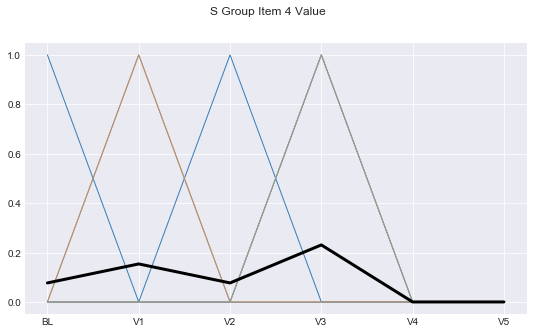

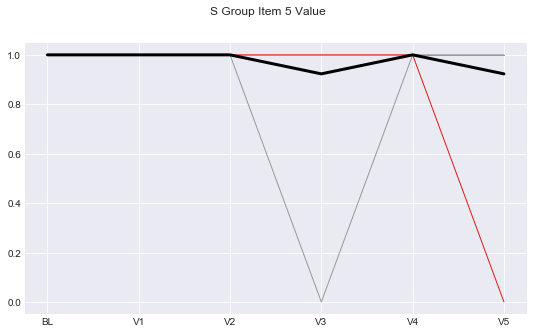

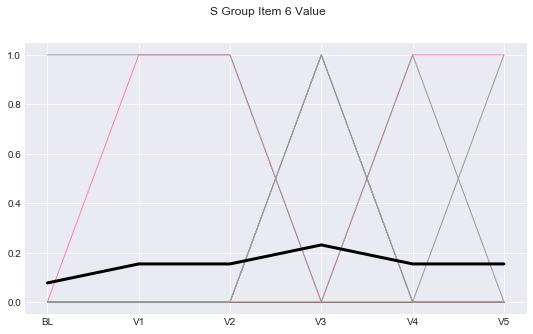

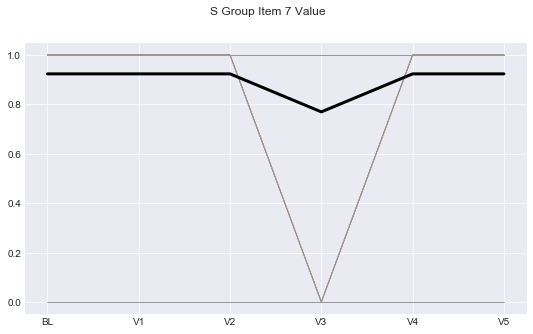

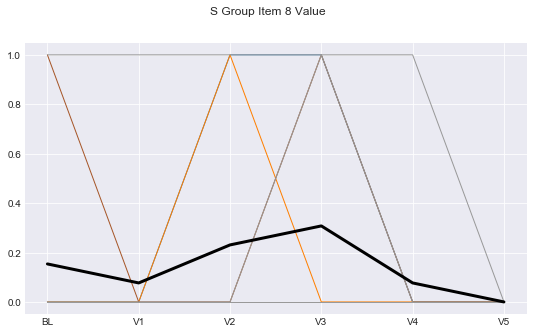

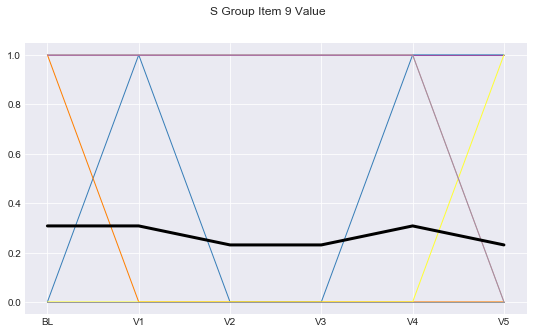

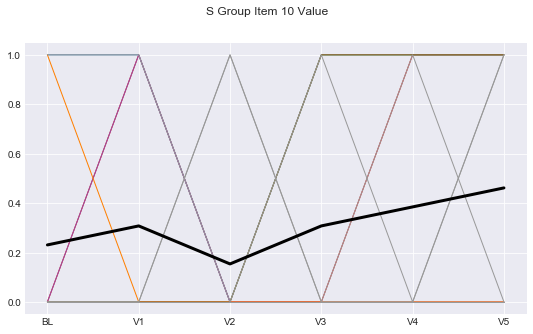

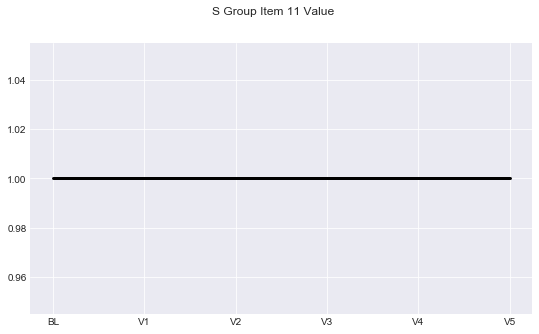

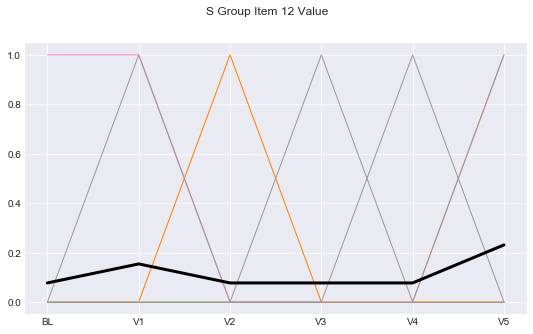

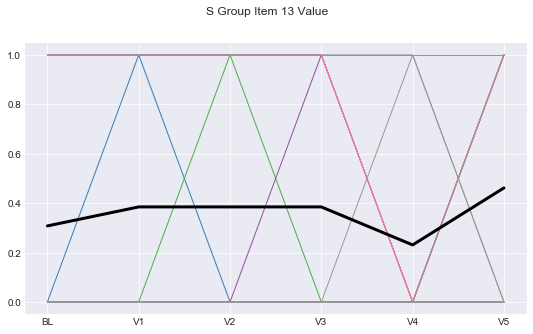

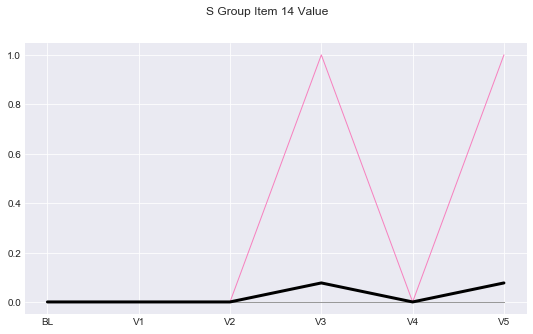

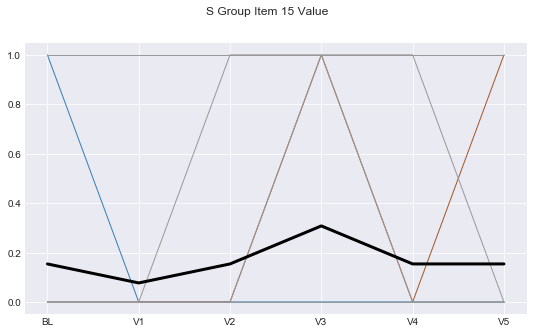

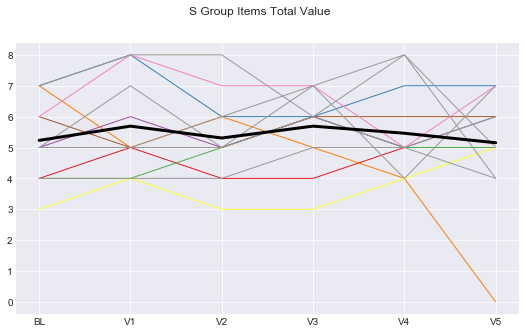

Original Data Plots


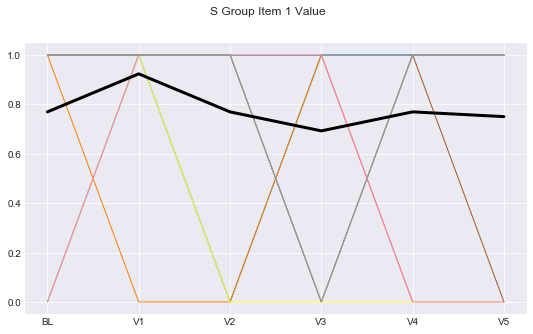

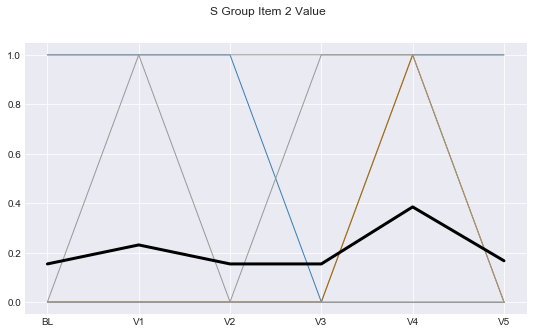

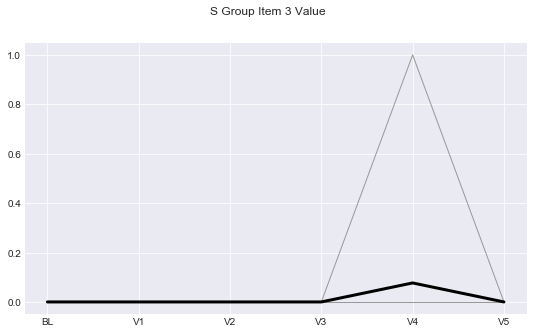

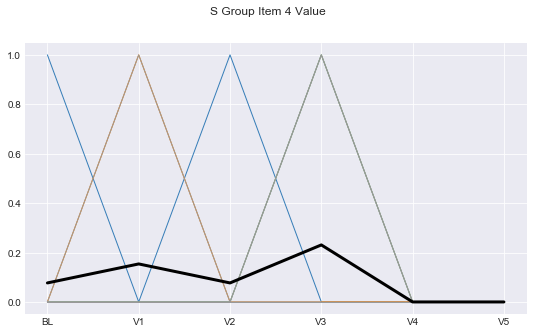

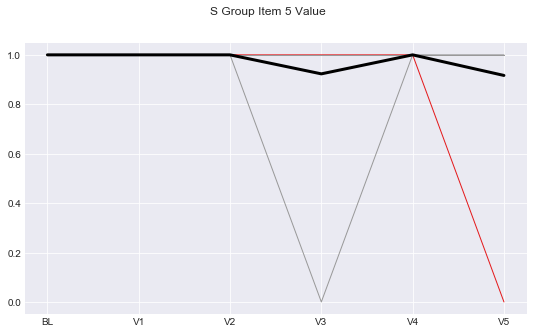

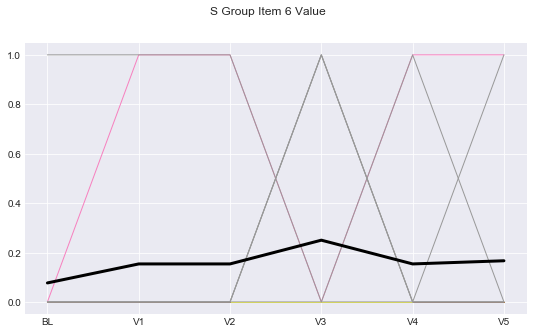

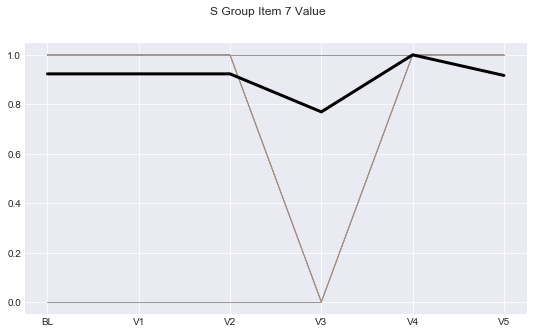

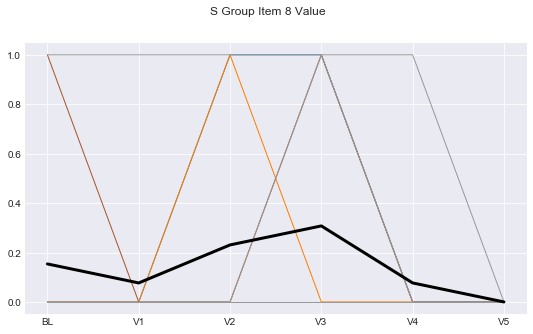

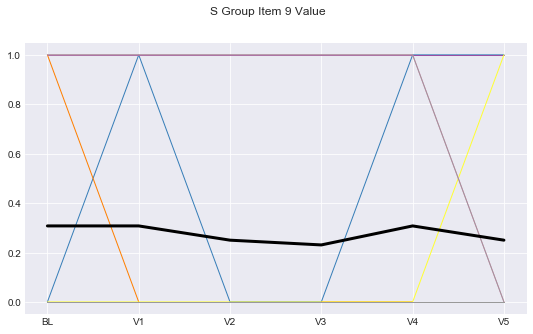

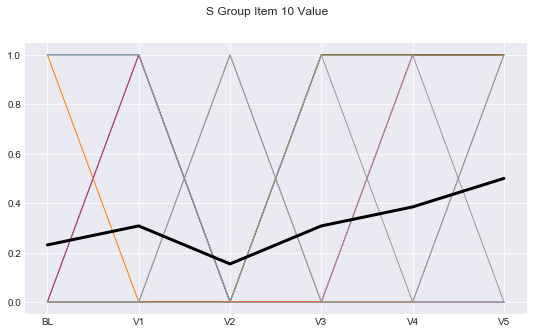

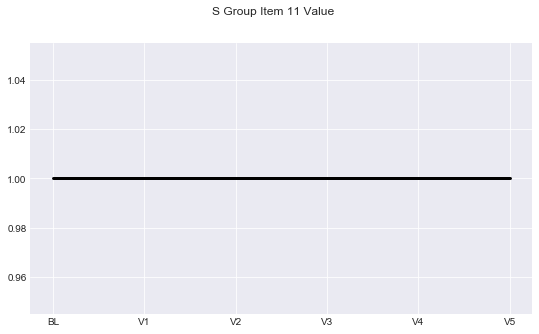

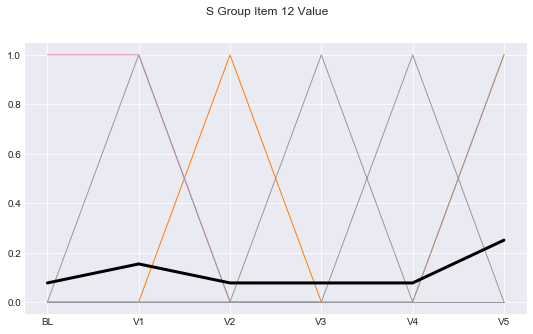

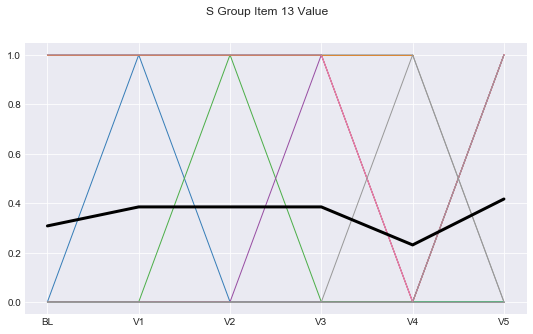

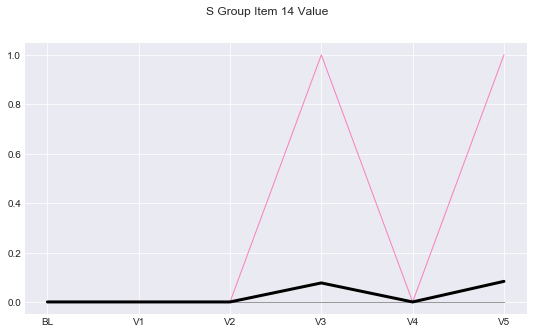

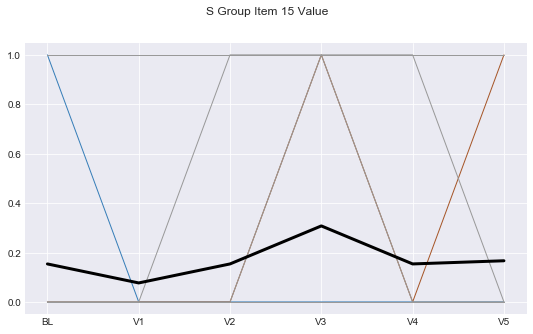

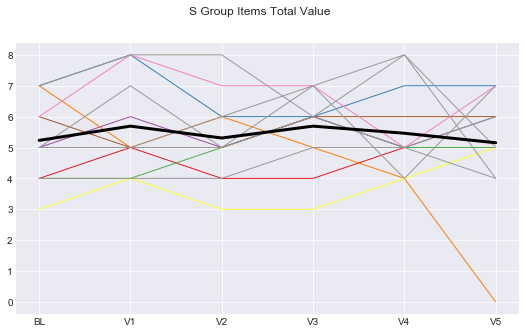

In [134]:
# Need to loop through the different subscores for each S and D
timepoints=['BL', 'V1', 'V2', 'V3', 'V4', 'V5']

# LOCF data
print('LOCF Data Plots')

count=1
for i in range(16):
    if i!=15:
        itemnum=str(count)
    S_item=S_gds_locf[items[i]]
    # Add a row for the mean of all patients at each tp
    S_item=S_item.append(S_item.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the item df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        S_plot=S_item.iloc[patient]
        plt.plot(timepoints, S_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, S_item.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=15:
        plt.suptitle('S Group Item '+itemnum+' Value')
    elif i==15:
        plt.suptitle('S Group Items Total Value')
    plt.show()
    count+=1

# Original data
print('Original Data Plots')

count=1
for i in range(16):
    if i!=15:
        itemnum=str(count)
    S_item=S_gds_orig[items[i]]
    # Add a row for the mean of all patients at each tp
    S_item=S_item.append(S_item.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the item df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        S_plot=S_item.iloc[patient]
        plt.plot(timepoints, S_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, S_item.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=15:
        plt.suptitle('S Group Item '+itemnum+' Value')
    elif i==15:
        plt.suptitle('S Group Items Total Value')
    plt.show()
    count+=1

Plot: D Group - Discussion First

LOCF Data Plots


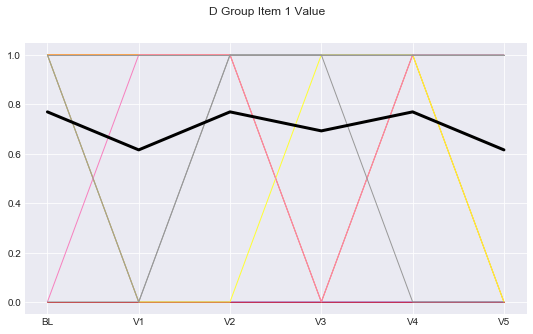

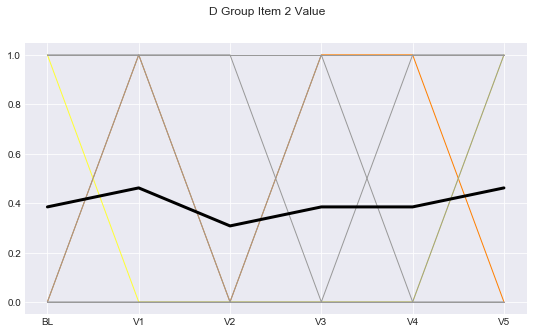

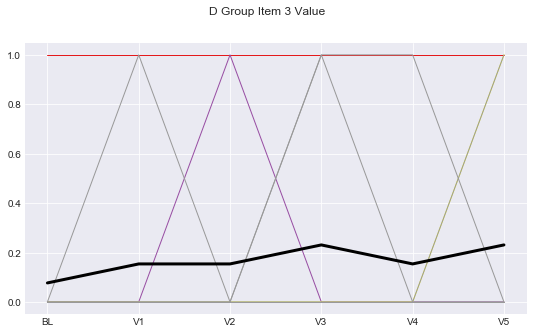

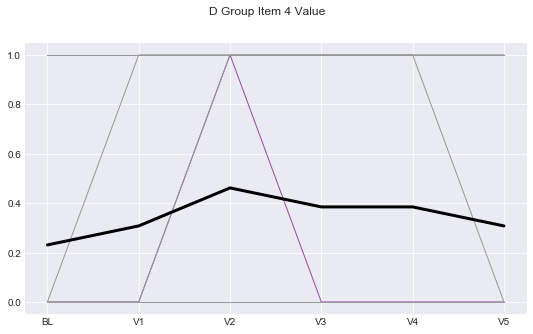

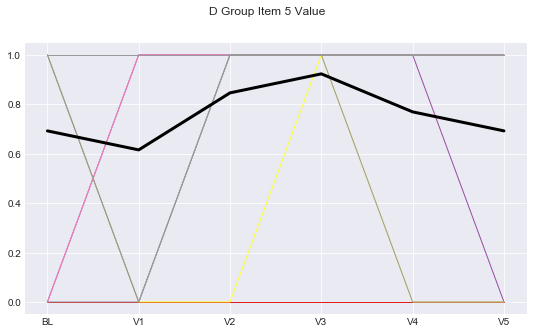

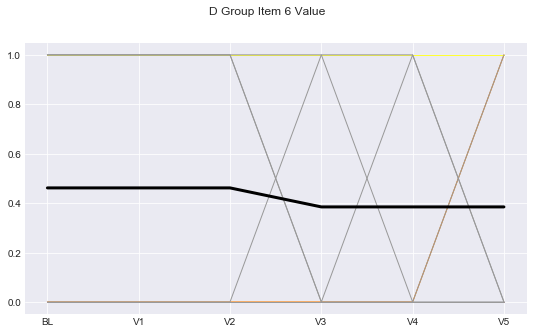

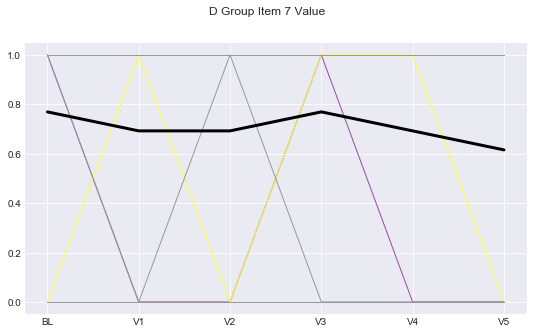

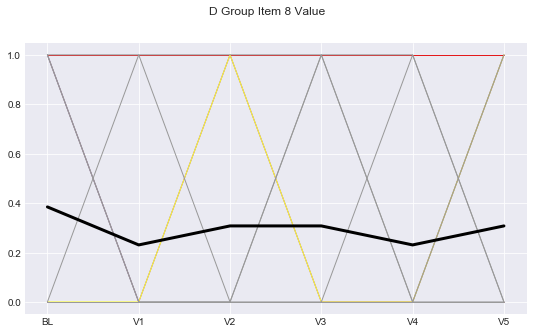

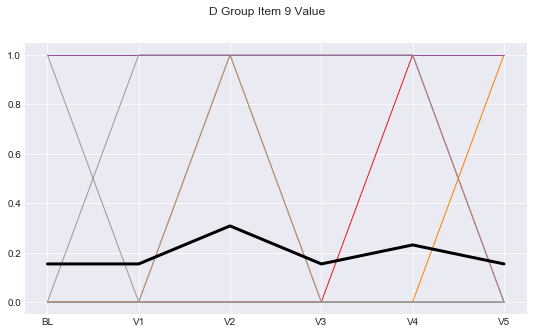

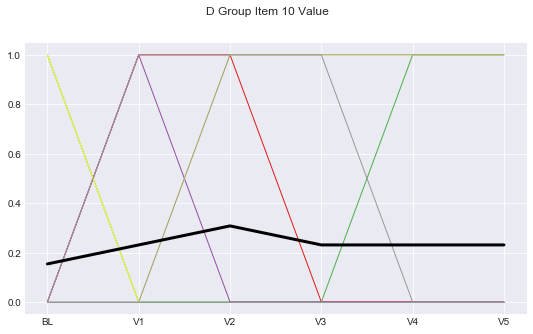

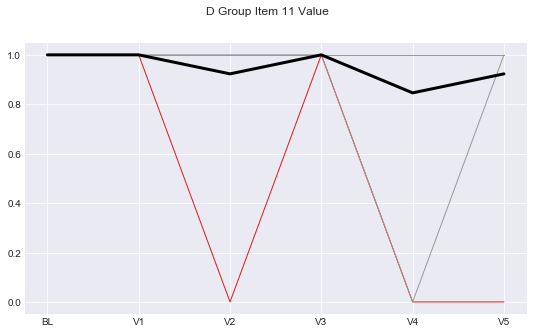

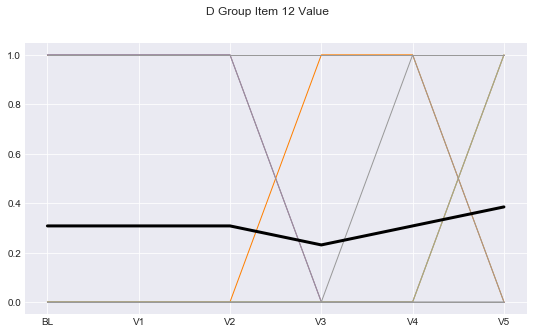

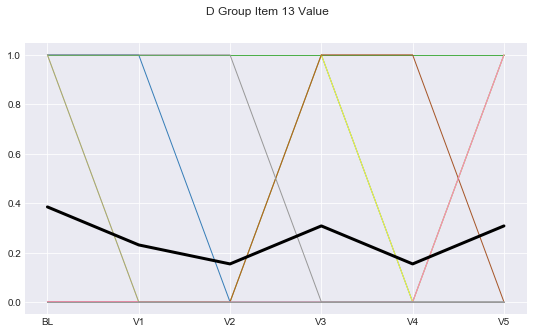

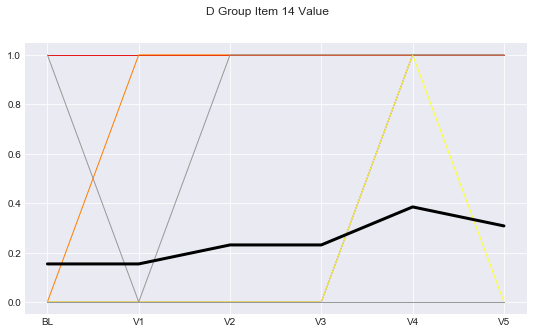

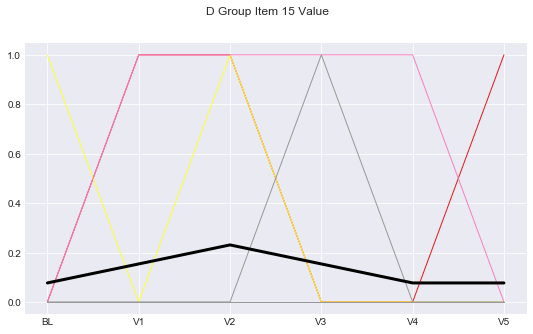

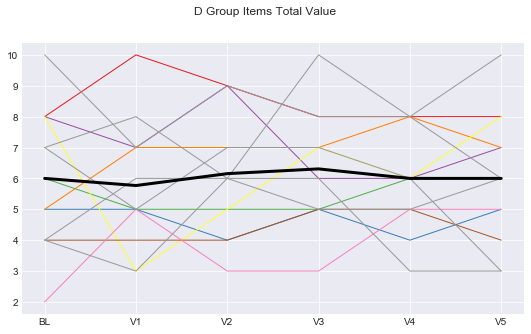

Original Data Plots


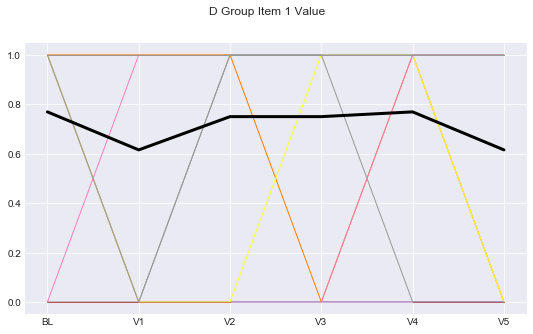

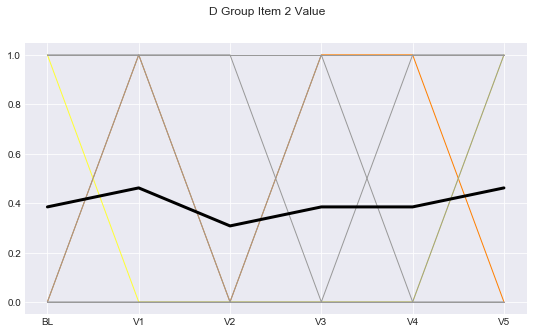

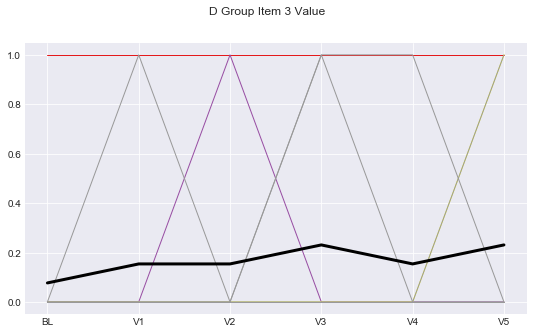

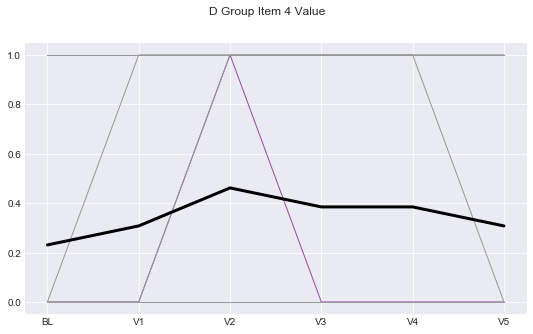

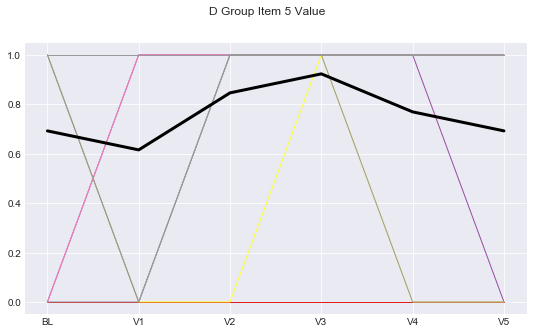

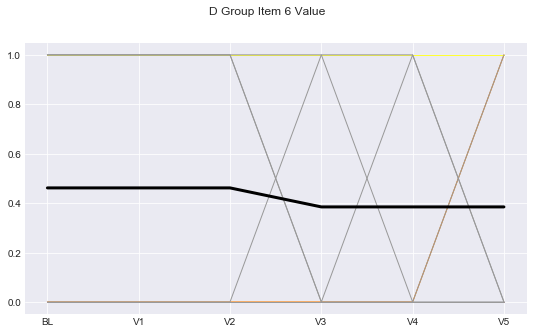

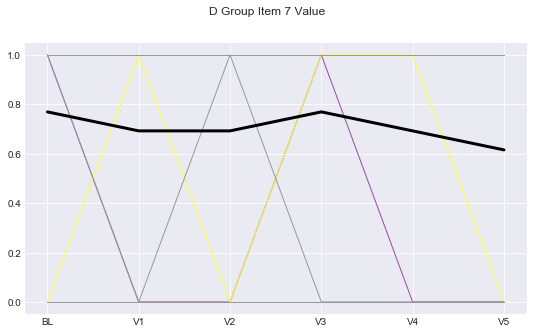

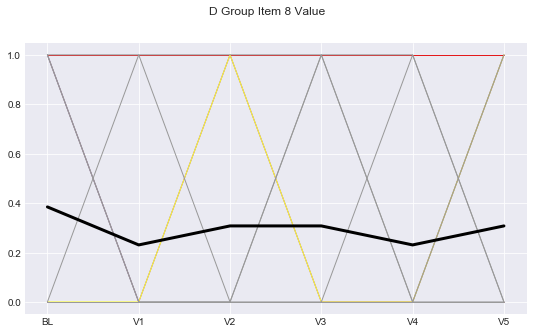

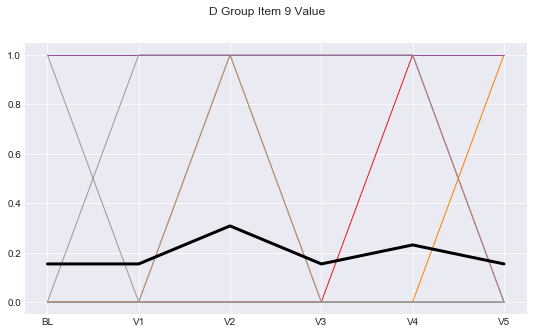

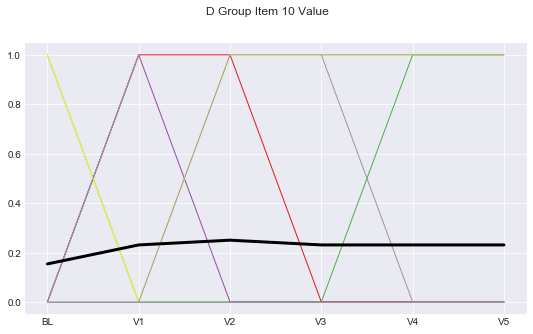

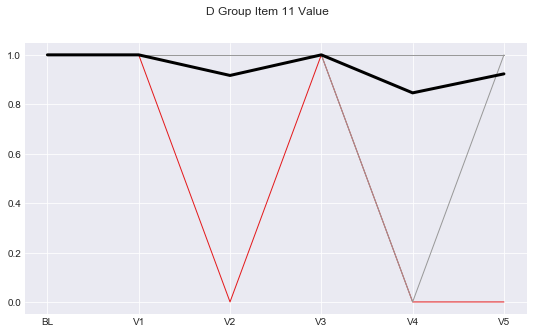

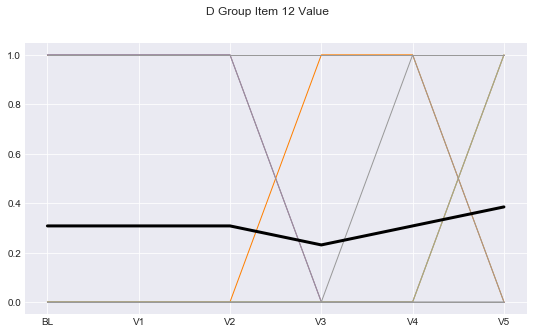

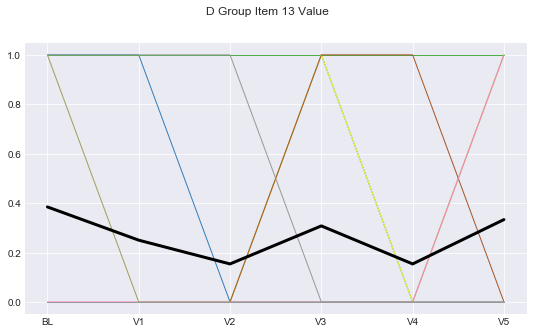

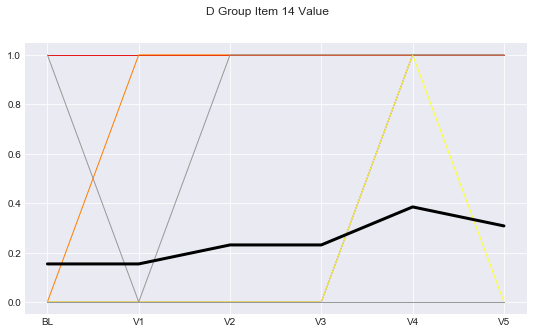

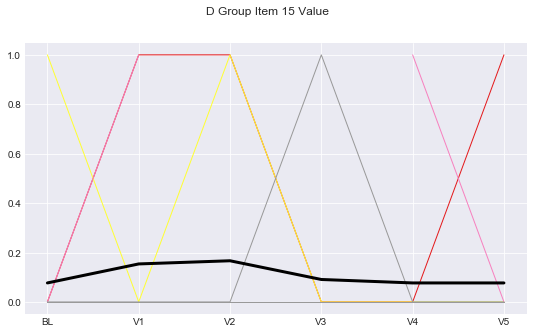

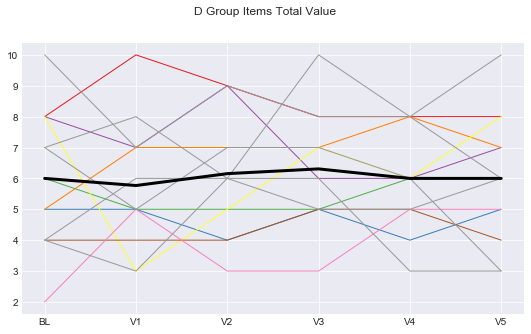

In [258]:
# Need to loop through the different subscores for each S and D
timepoints=['BL', 'V1', 'V2', 'V3', 'V4', 'V5']

# LOCF data
print('LOCF Data Plots')

count=1
for i in range(16):
    if i!=15:
        itemnum=str(count)
    D_item=D_gds_locf[items[i]]
    # Add a row for the mean of all patients at each tp
    D_item=D_item.append(D_item.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the item df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        D_plot=D_item.iloc[patient]
        plt.plot(timepoints, D_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, D_item.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=15:
        plt.suptitle('D Group Item '+itemnum+' Value')
    elif i==15:
        plt.suptitle('D Group Items Total Value')
    plt.show()
    count+=1

# Original data
print('Original Data Plots')

count=1
for i in range(16):
    if i!=15:
        itemnum=str(count)
    D_item=D_gds_orig[items[i]]
    # Add a row for the mean of all patients at each tp
    D_item=D_item.append(D_item.iloc[:, :].mean(axis=0), ignore_index=True)
    # Next loop through the item df and plot each individual patient
    plt.style.use('seaborn-darkgrid')
    palette=plt.get_cmap('Set1')
    num=0
    for patient in range(13):
        D_plot=D_item.iloc[patient]
        plt.plot(timepoints, D_plot[1:], marker='', color=palette(num), linewidth=1)
        num+=1
    # Plot mean of all patients
    plt.plot(timepoints, D_item.iloc[13][1:], marker='', color='black', linewidth=3)
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    if i!=15:
        plt.suptitle('D Group Item '+itemnum+' Value')
    elif i==15:
        plt.suptitle('D Group Items Total Value')
    plt.show()
    count+=1

Plot data from 1. participants with missing data for comparison with 2. participants with intact data

In [13]:
miss_item

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Comparison Data Plots
S Group Plots


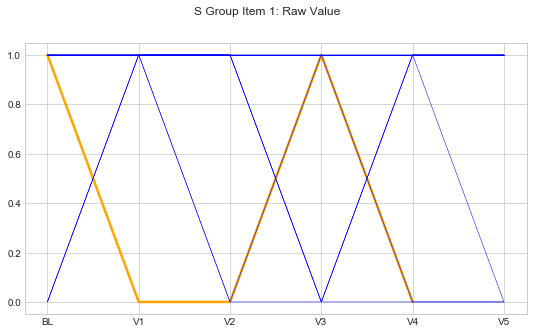

D Group Plots


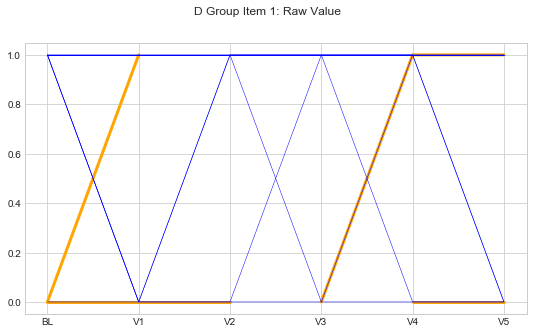

S Group Plots


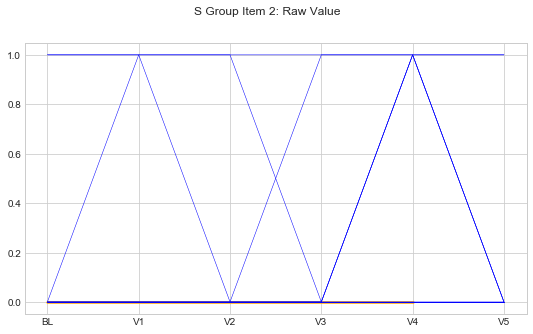

D Group Plots


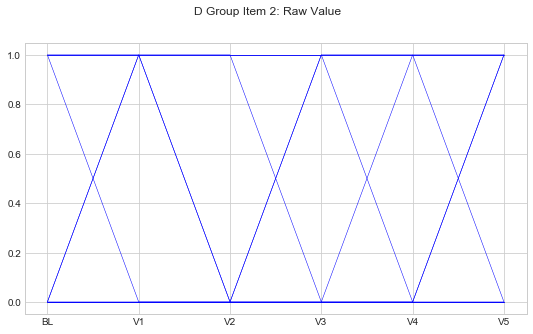

S Group Plots


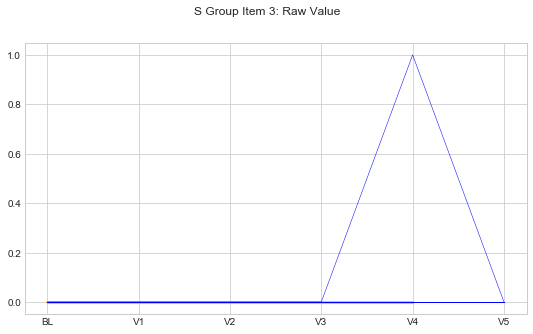

D Group Plots


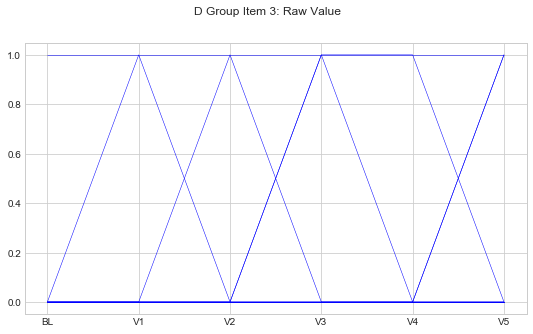

S Group Plots


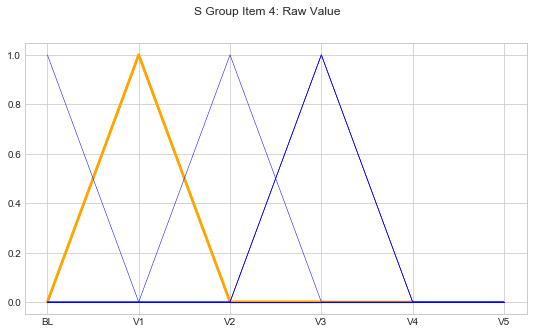

D Group Plots


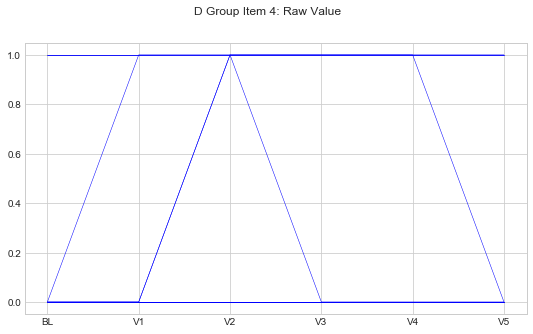

S Group Plots


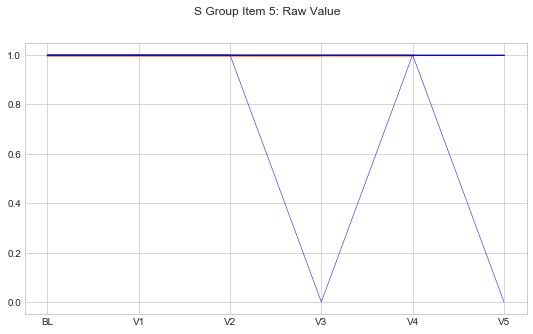

D Group Plots


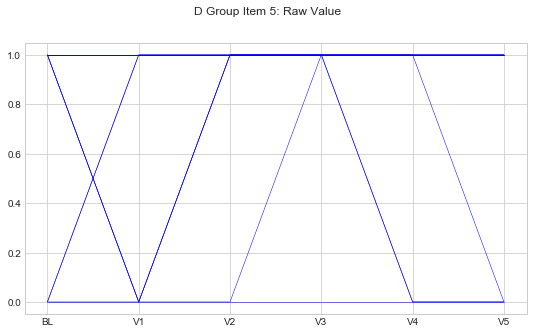

S Group Plots


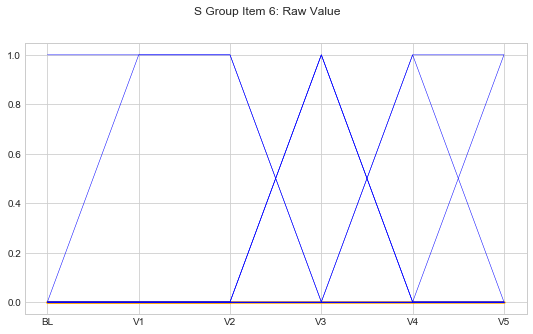

D Group Plots


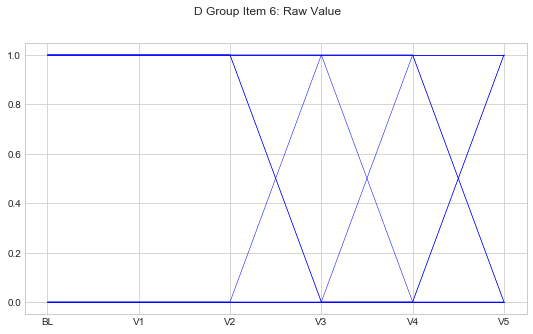

S Group Plots


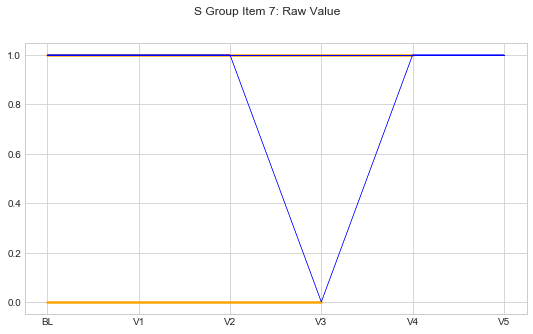

D Group Plots


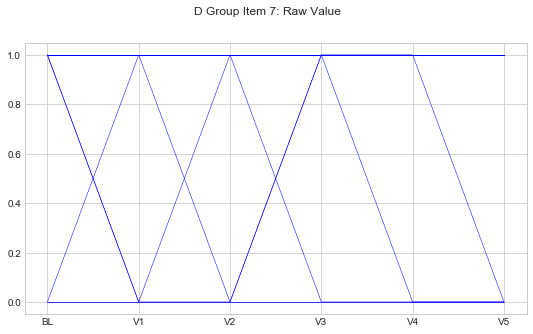

S Group Plots


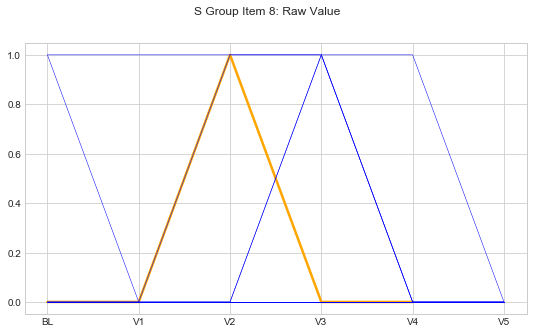

D Group Plots


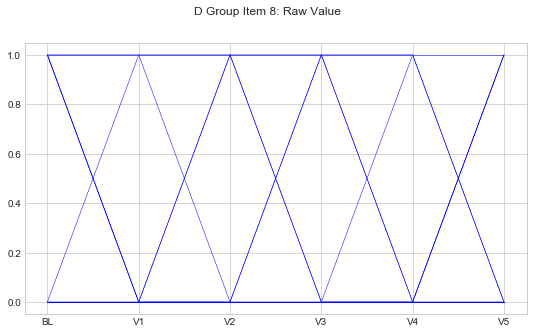

S Group Plots


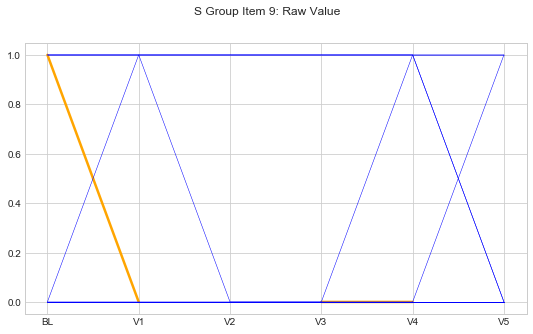

D Group Plots


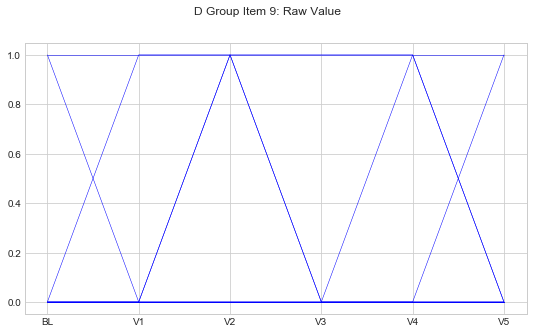

S Group Plots


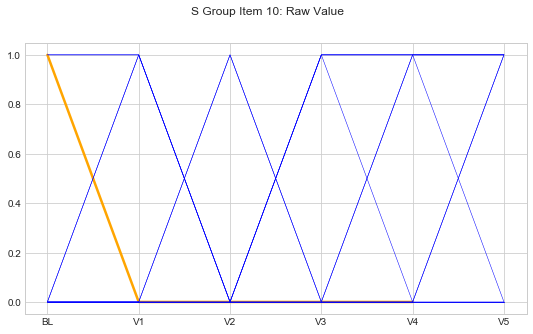

D Group Plots


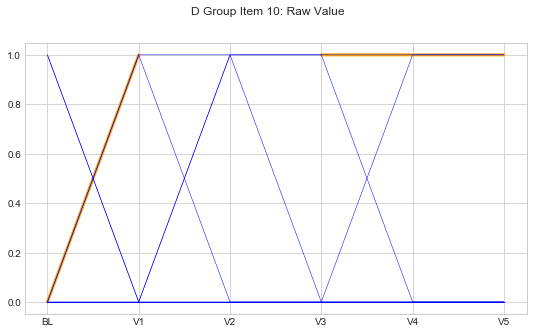

S Group Plots


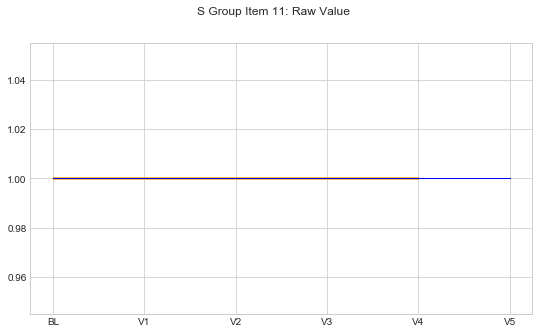

D Group Plots


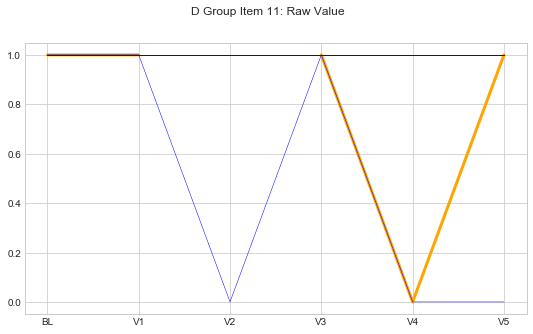

S Group Plots


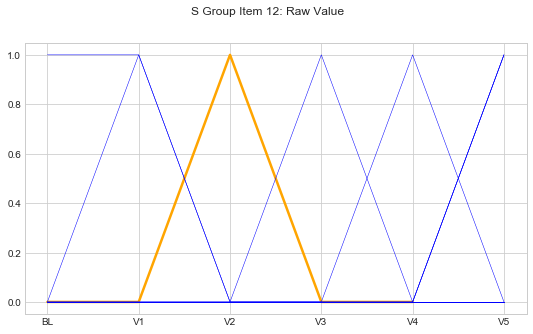

D Group Plots


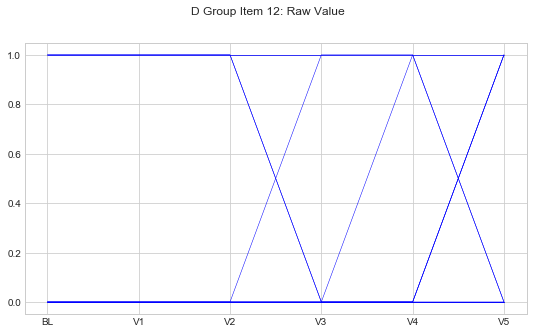

S Group Plots


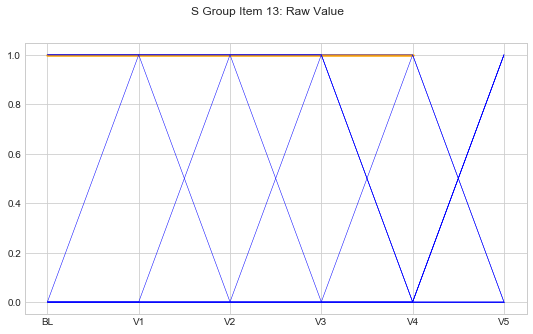

D Group Plots


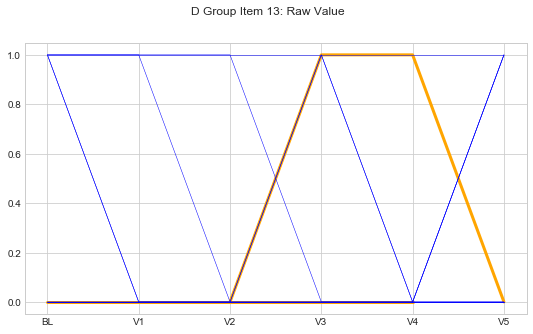

S Group Plots


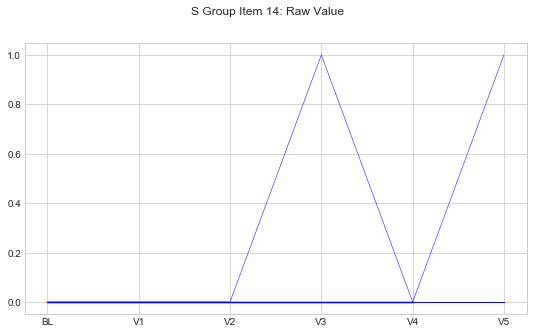

D Group Plots


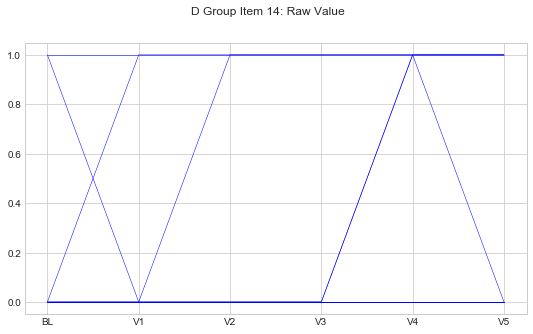

S Group Plots


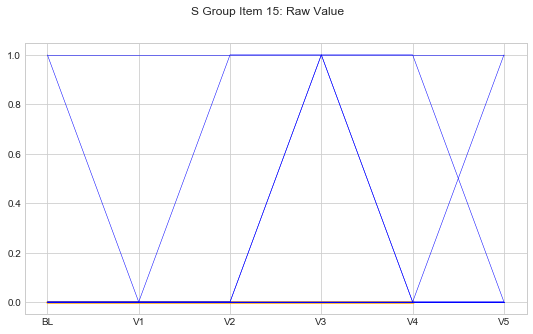

D Group Plots


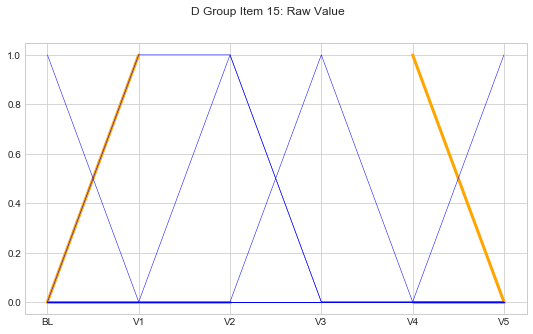

In [260]:
print('Comparison Data Plots')

count=1
for listnum in range(len(miss_group)):
    subgroup=miss_group[listnum]
    subID=miss_ID[listnum]
    plot_item=miss_item[listnum]
    
    miss_S=[]
    miss_D=[]
    for j in range(len(subgroup)):
        if subgroup[j]=='S':
            miss_S.append(subID[j])
        if subgroup[j]=='D':
            miss_D.append(subID[j])
    
    plt.style.use('seaborn-whitegrid')
    palette=plt.get_cmap('Set3')
    
    print('S Group Plots')
    full_S=S_group['ID'].astype('int').tolist()
    for pnum in range(len(miss_S)):
        miss_S_plot=S_gds_orig[items[plot_item]].loc[S_gds_orig['ID']==miss_S[pnum]].iloc[0]
        plt.plot(timepoints, miss_S_plot[1:], marker='', color='#FFA500', linewidth=2.5)
        full_S.remove(miss_S[pnum])
    for pnum in range(len(full_S)):
        full_S_plot=S_gds_orig[items[plot_item]].loc[S_gds_orig['ID']==full_S[pnum]].iloc[0]
        plt.plot(timepoints, full_S_plot[1:], marker='', color='blue', linewidth=0.5)
      
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    plt.suptitle('S Group Item '+str(plot_item+1)+': Raw Value')
    plt.show()
    
    print('D Group Plots')
    full_D=D_group['ID'].astype('int').tolist()
    for pnum in range(len(miss_D)):
        miss_D_plot=D_gds_orig[items[plot_item]].loc[D_gds_orig['ID']==miss_D[pnum]].iloc[0]
        plt.plot(timepoints, miss_D_plot[1:], marker='', color='#FFA500', linewidth=3)
        full_D.remove(miss_D[pnum])
    for pnum in range(len(full_D)):
        full_D_plot=D_gds_orig[items[plot_item]].loc[D_gds_orig['ID']==full_D[pnum]].iloc[0]
        plt.plot(timepoints, full_D_plot[1:], marker='', color='blue', linewidth=0.5)
      
    fig=plt.gcf()
    fig.set_size_inches(9,5)
    plt.suptitle('D Group Item '+str(plot_item+1)+': Raw Value')
    plt.show()
    

# Groupwise Pre-Post

Does singing better GDS subscores?

Pre-post intervention: Raw value comparisons 
S: BL vs V2 and D: V2 vs V4

LOCF Data Plots


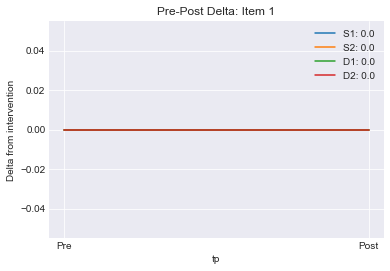

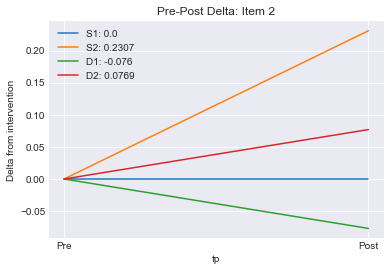

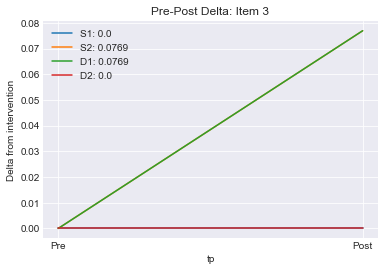

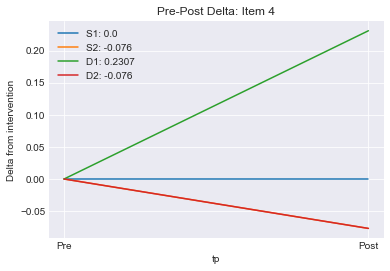

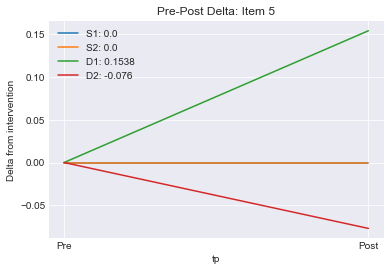

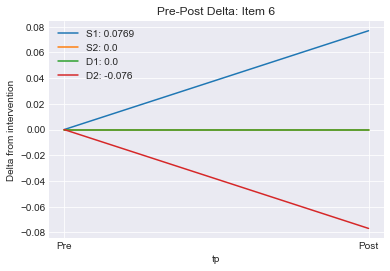

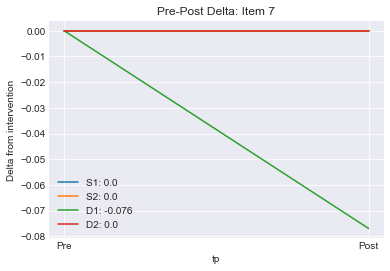

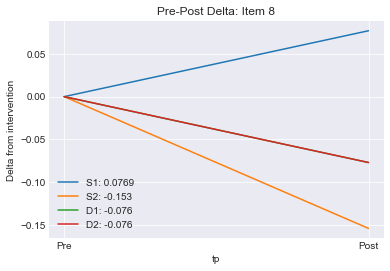

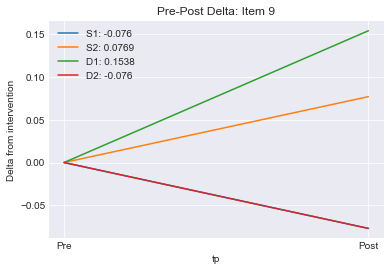

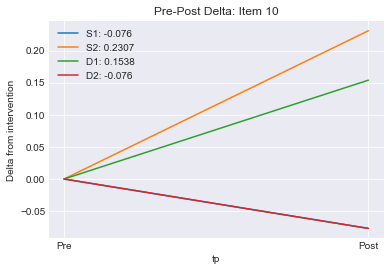

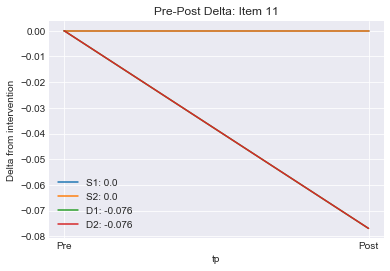

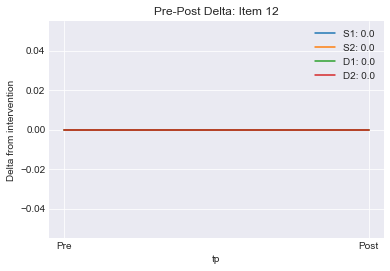

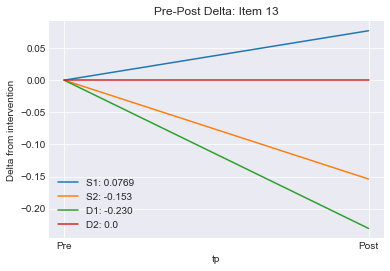

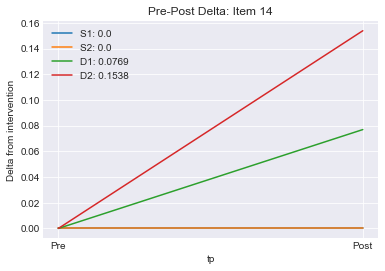

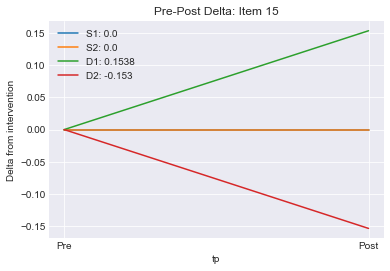

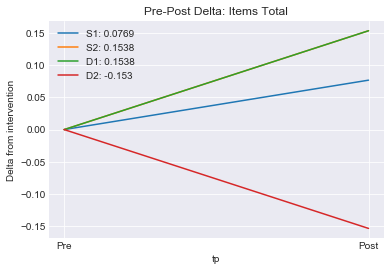

Original Data Plots


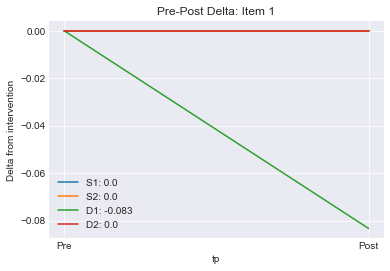

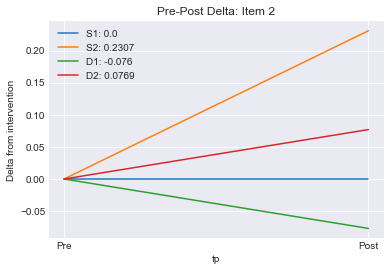

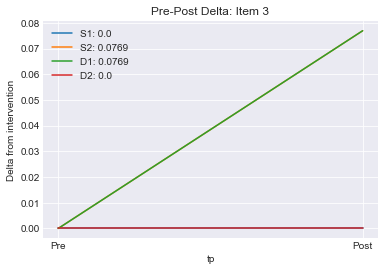

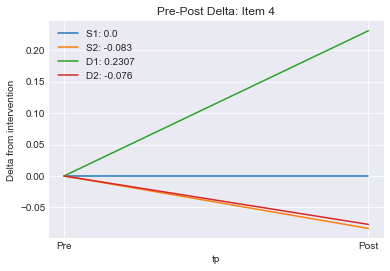

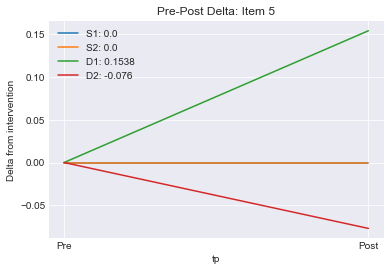

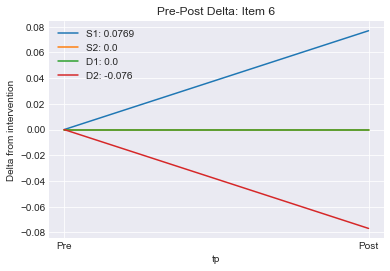

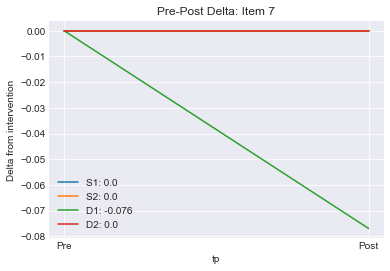

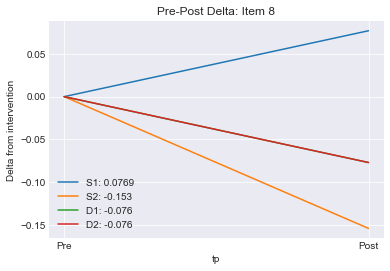

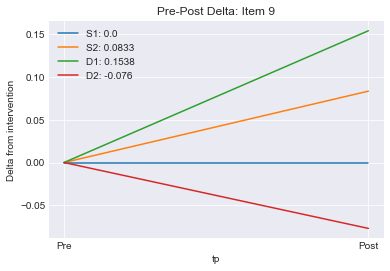

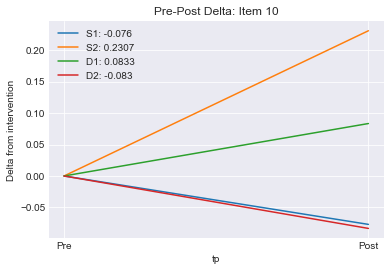

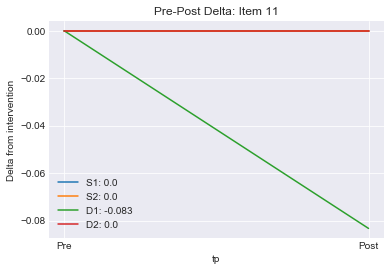

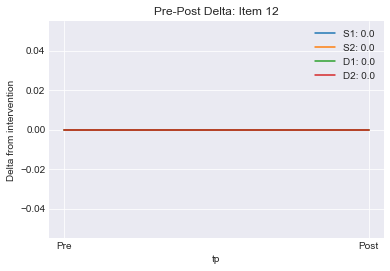

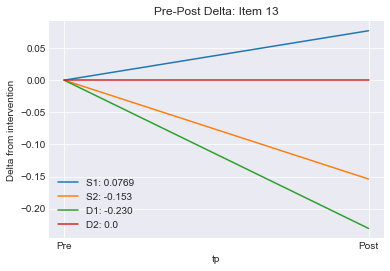

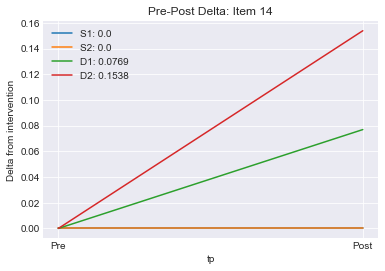

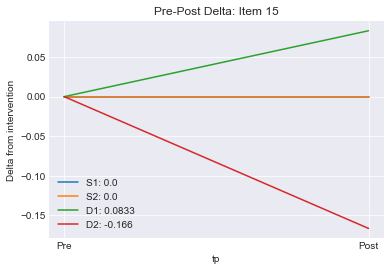

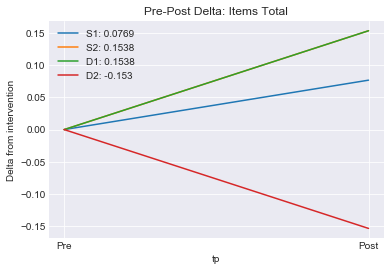

In [14]:
# Plots: want to compare gradients of the 4 groups' DELTAS
# Make lineplots of all 4 groups on one plot for eachof the voice measures

tp=['Post', 'Pre']

# LOCF Data 
print('LOCF Data Plots')
for i in range(16):
    if i!=15:
        scorename='Item '+str(i+1)
    if i==15:
        scorename='Items Total'
    temp_S=S_gds_locf[items[i]].iloc[:, np.r_[1,3,5]]
    temp_D=D_gds_locf[items[i]].iloc[:, np.r_[1,3,5]]
    temp_S_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_D_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_S_delta['Delta V2-BL']=temp_S.iloc[:,1]-temp_S.iloc[:,0]
    temp_S_delta['Delta V4-V2']=temp_S.iloc[:,2]-temp_S.iloc[:,1]
    temp_S_delta['Zero']=0
    temp_D_delta['Delta V2-BL']=temp_D.iloc[:,1]-temp_D.iloc[:,0]
    temp_D_delta['Delta V4-V2']=temp_D.iloc[:,2]-temp_D.iloc[:,1]
    temp_D_delta['Zero']=0
    temp_S_avg=temp_S_delta.mean(axis=0)
    temp_D_avg=temp_D_delta.mean(axis=0)
    
    delta_df=pd.DataFrame(columns=['tp'])
    delta_df['tp']=tp
    delta_df.sort_values('tp', ascending=False, inplace=True)
    delta_df['S1']=temp_S_avg[:2].values
    delta_df['S2']=temp_S_avg[2:].values
    delta_df['D1']=temp_D_avg[:2].values
    delta_df['D2']=temp_D_avg[2:].values
    
    plt.figure()
    sns.lineplot(x='tp', y='S1', data=delta_df, sort=False, label='S1: '+str(delta_df['S1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='S2', data=delta_df, sort=False, label='S2: '+str(delta_df['S2'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D1', data=delta_df, sort=False, label='D1: '+str(delta_df['D1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D2', data=delta_df, sort=False, label='D2: '+str(delta_df['D2'].iloc[1])[0:6]).set_title('Pre-Post Delta: '+scorename)
    plt.ylabel('Delta from intervention')
    plt.show()
    
# Original Data 
print('Original Data Plots')
for i in range(16):
    if i!=15:
        scorename='Item '+str(i+1)
    if i==15:
        scorename='Items Total'
    temp_S=S_gds_orig[items[i]].iloc[:, np.r_[1,3,5]]
    temp_D=D_gds_orig[items[i]].iloc[:, np.r_[1,3,5]]
    temp_S_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_D_delta=pd.DataFrame(columns=['Zero', 'Delta V2-BL', 'Zero', 'Delta V4-V2'])
    temp_S_delta['Delta V2-BL']=temp_S.iloc[:,1]-temp_S.iloc[:,0]
    temp_S_delta['Delta V4-V2']=temp_S.iloc[:,2]-temp_S.iloc[:,1]
    temp_S_delta['Zero']=0
    temp_D_delta['Delta V2-BL']=temp_D.iloc[:,1]-temp_D.iloc[:,0]
    temp_D_delta['Delta V4-V2']=temp_D.iloc[:,2]-temp_D.iloc[:,1]
    temp_D_delta['Zero']=0
    temp_S_avg=temp_S_delta.mean(axis=0)
    temp_D_avg=temp_D_delta.mean(axis=0)
    
    delta_df=pd.DataFrame(columns=['tp'])
    delta_df['tp']=tp
    delta_df.sort_values('tp', ascending=False, inplace=True)
    delta_df['S1']=temp_S_avg[:2].values
    delta_df['S2']=temp_S_avg[2:].values
    delta_df['D1']=temp_D_avg[:2].values
    delta_df['D2']=temp_D_avg[2:].values
    
    plt.figure()
    sns.lineplot(x='tp', y='S1', data=delta_df, sort=False, label='S1: '+str(delta_df['S1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='S2', data=delta_df, sort=False, label='S2: '+str(delta_df['S2'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D1', data=delta_df, sort=False, label='D1: '+str(delta_df['D1'].iloc[1])[0:6])
    sns.lineplot(x='tp', y='D2', data=delta_df, sort=False, label='D2: '+str(delta_df['D2'].iloc[1])[0:6]).set_title('Pre-Post Delta: '+scorename)
    plt.ylabel('Delta from intervention')
    plt.show()

In [15]:
# Create 4 initial dfs to append to within each loop

# LOCF Data
s1_locf=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'])
s2_locf=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'])
d1_locf=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'])
d2_locf=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'])
sdlist=[s1_locf, s2_locf, d1_locf, d2_locf]

count=1
for i in range(16):
    if i!=15:
        itemnum=str(i+1)
    elif i==15:
        itemnum='Total'
    # Make a list of temp dataframes to iterate thru
    s1_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    s2_temp=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    d1_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    d2_temp=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    tempdflist=[s1_temp, s2_temp, d1_temp, d2_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_gds=S_gds_locf[items[i]].iloc[:, 1:4]
    s2_gds=S_gds_locf[items[i]].iloc[:, 4:]
    d1_gds=D_gds_locf[items[i]].iloc[:, 1:4]
    d2_gds=D_gds_locf[items[i]].iloc[:, 4:]
    gdsdflist=[s1_gds, s2_gds, d1_gds, d2_gds]

    for j in range(4):
        tempdf=tempdflist[j]
        tempgds=gdsdflist[j]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(tempgds.iloc[:, 0], tempgds.iloc[:, 2], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempgds.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempgds.iloc[:, 2])

        if j==0:
            s1_locf=pd.concat([s1_locf, tempdf], sort=False)
        elif j==1:
            s2_locf=pd.concat([s2_locf, tempdf], sort=False)
        elif j==2:
            d1_locf=pd.concat([d1_locf, tempdf], sort=False)
        elif j==3:
            d2_locf=pd.concat([d2_locf, tempdf], sort=False)
    count+=1
    
# Original Data
s1_orig=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'])
s2_orig=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'])
d1_orig=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'])
d2_orig=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'])
sdlist=[s1_orig, s2_orig, d1_orig, d2_orig]

count=1
for i in range(16):
    if i!=15:
        itemnum=str(i+1)
    elif i==15:
        itemnum='Total'
    # Make a list of temp dataframes to iterate thru
    s1_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    s2_temp=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    d1_temp=pd.DataFrame(columns=['Item #', 'pval', 'BL Mean', 'V2 Mean'], index=[str(count)])
    d2_temp=pd.DataFrame(columns=['Item #', 'pval', 'V2 Mean', 'V4 Mean'], index=[str(count)])
    tempdflist=[s1_temp, s2_temp, d1_temp, d2_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_gds=S_gds_orig[items[i]].iloc[:, 1:4]
    s2_gds=S_gds_orig[items[i]].iloc[:, 4:]
    d1_gds=D_gds_orig[items[i]].iloc[:, 1:4]
    d2_gds=D_gds_orig[items[i]].iloc[:, 4:]
    gdsdflist=[s1_gds, s2_gds, d1_gds, d2_gds]

    for j in range(4):
        tempdf=tempdflist[j]
        tempgds=gdsdflist[j]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(tempgds.iloc[:, 0], tempgds.iloc[:, 2], nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(tempgds.iloc[:, 0])
        tempdf.iloc[:, 3]=np.mean(tempgds.iloc[:, 2])

        if j==0:
            s1_orig=pd.concat([s1_orig, tempdf], sort=False)
        elif j==1:
            s2_orig=pd.concat([s2_orig, tempdf], sort=False)
        elif j==2:
            d1_orig=pd.concat([d1_orig, tempdf], sort=False)
        elif j==3:
            d2_orig=pd.concat([d2_orig, tempdf], sort=False)
    count+=1

C:\Users\kevin\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\kevin\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\kevin\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [23]:
d2_locf

Item #      pval   V2 Mean    V4 Mean
1       1  0.584493  0.692308   0.615385
2       2  0.672686  0.384615   0.461538
3       3  1.000000  0.230769   0.230769
4       4  0.337049  0.384615   0.307692
5       5  0.082097  0.923077   0.692308
6       6  1.000000  0.384615   0.384615
7       7  0.165407  0.769231   0.615385
8       8  1.000000  0.307692   0.307692
9       9  1.000000  0.153846   0.153846
10     10  1.000000  0.230769   0.230769
11     11  0.337049         1   0.923077
12     12  0.337049  0.230769   0.384615
13     13  1.000000  0.307692   0.307692
14     14  0.337049  0.230769   0.307692
15     15  0.584493  0.153846  0.0769231
16  Total  0.606425   6.30769          6

In [193]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
s1_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\LOCF\GDS15_TTest_Groupwise_S1_LOCF.xlsx')
s2_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\LOCF\GDS15_TTest_Groupwise_S2_LOCF.xlsx')
d1_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\LOCF\GDS15_TTest_Groupwise_D1_LOCF.xlsx')
d2_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\LOCF\GDS15_TTest_Groupwise_D2_LOCF.xlsx')

s1_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\Original\GDS15_TTest_Groupwise_S1_Orig.xlsx')
s2_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\Original\GDS15_TTest_Groupwise_S2_Orig.xlsx')
d1_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\Original\GDS15_TTest_Groupwise_D1_Orig.xlsx')
d2_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\Original\GDS15_TTest_Groupwise_D2_Orig.xlsx')

# Groupwise Delta Significance Testing

Compare deltas of S1 to S2, D1 to D2

In [24]:
# LOCF Data

# Create 4 initial dfs to append to within each loop
s_locf=pd.DataFrame(columns=['Item #', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'])
d_locf=pd.DataFrame(columns=['Item #', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'])
dflist=[s_locf, d_locf]

count=1
# test with mobility first
for i in range(16):
    if i!=15:
        itemnum=str(count)
    elif i==15:
        itemnum='Total'
    # Make a list of temp dataframes to iterate thru
    s_locf_temp=pd.DataFrame(columns=['Item #', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'], index=[str(count)])
    d_locf_temp=pd.DataFrame(columns=['Item #', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'], index=[str(count)])
    tempdflist=[s_locf_temp, d_locf_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_delta=S_gds_locf[items[i]].iloc[:,3]-S_gds_locf[items[i]].iloc[:,1]
    s2_delta=S_gds_locf[items[i]].iloc[:,5]-S_gds_locf[items[i]].iloc[:,3]
    d1_delta=D_gds_locf[items[i]].iloc[:,3]-D_gds_locf[items[i]].iloc[:,1]
    d2_delta=D_gds_locf[items[i]].iloc[:,5]-D_gds_locf[items[i]].iloc[:,3]
    deltadflist=[[s1_delta, s2_delta], [d1_delta, d2_delta]]

    for j in range(2):
        tempdf=tempdflist[j]
        delta1=deltadflist[j][0]
        delta2=deltadflist[j][1]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(delta1, delta2, nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(delta1)
        tempdf.iloc[:, 3]=np.mean(delta2)

        if j==0:
            s_locf=pd.concat([s_locf, tempdf], sort=False)
        elif j==1:
            d_locf=pd.concat([d_locf, tempdf], sort=False)
    count+=1
    
# Original Data

# Create 4 initial dfs to append to within each loop
s_orig=pd.DataFrame(columns=['Item #', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'])
d_orig=pd.DataFrame(columns=['Item #', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'])
dflist=[s_orig, d_orig]

count=1
# test with mobility first
for i in range(16):
    if i!=15:
        itemnum=str(count)
    elif i==15:
        itemnum='Total'
    # Make a list of temp dataframes to iterate thru
    s_orig_temp=pd.DataFrame(columns=['Item #', 'pval', 'S1 Mean Delta', 'S2 Mean Delta'], index=[str(count)])
    d_orig_temp=pd.DataFrame(columns=['Item #', 'pval', 'D1 Mean Delta', 'D2 Mean Delta'], index=[str(count)])
    tempdflist=[s_orig_temp, d_orig_temp]

    # Make list of dataframes with the data s1-d2 to correspond to the temp dfs
    s1_delta=S_gds_orig[items[i]].iloc[:,3]-S_gds_orig[items[i]].iloc[:,1]
    s2_delta=S_gds_orig[items[i]].iloc[:,5]-S_gds_orig[items[i]].iloc[:,3]
    d1_delta=D_gds_orig[items[i]].iloc[:,3]-D_gds_orig[items[i]].iloc[:,1]
    d2_delta=D_gds_orig[items[i]].iloc[:,5]-D_gds_orig[items[i]].iloc[:,3]
    deltadflist=[[s1_delta, s2_delta], [d1_delta, d2_delta]]

    for j in range(2):
        tempdf=tempdflist[j]
        delta1=deltadflist[j][0]
        delta2=deltadflist[j][1]
        tempdf['Item #']=itemnum
        tempdf['pval']=stats.ttest_rel(delta1, delta2, nan_policy='omit').pvalue
        tempdf.iloc[:, 2]=np.mean(delta1)
        tempdf.iloc[:, 3]=np.mean(delta2)

        if j==0:
            s_orig=pd.concat([s_orig, tempdf], sort=False)
        elif j==1:
            d_orig=pd.concat([d_orig, tempdf], sort=False)
    count+=1

In [25]:
s_locf

Item #      pval S1 Mean Delta S2 Mean Delta
1       1  1.000000             0             0
2       2  0.082097             0      0.230769
3       3  0.337049             0     0.0769231
4       4  0.337049             0    -0.0769231
5       5       NaN             0             0
6       6  0.584493     0.0769231             0
7       7       NaN             0             0
8       8  0.337049     0.0769231     -0.153846
9       9  0.165407    -0.0769231     0.0769231
10     10  0.303314    -0.0769231      0.230769
11     11       NaN             0             0
12     12  1.000000             0             0
13     13  0.273484     0.0769231     -0.153846
14     14       NaN             0             0
15     15  1.000000             0             0
16  Total  0.850608     0.0769231      0.153846

In [26]:
# Write dfs to excel
# *****Don't rerun on startup, will mess up sizing and highlights******
s_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\LOCF\GDS15_TTest_SDelta.xlsx')
d_locf.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\LOCF\GDS15_TTest_DDelta.xlsx')

s_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\Original\GDS15_TTest_SDelta.xlsx')
d_orig.to_excel(r'C:\Users\kevin\Documents\JHU\Labs\Parkinsonics\Other Measures Analysis\GDS15\Original\GDS15_TTest_DDelta.xlsx')